# Model Explainability 

This notebook aims at showing the model explainability for the solution.

This note book is divided into multiple sections:
1. Understand the error per hierarchy level
2. Understand the error over time
3. Understand the error using SHAPS

## 00. Set up

The set up steps consist of: 
1. Import the packages to be used. 
2. Load the model to analyze.

In [ ]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


In [74]:
from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_104658/model_0.pickle'
)
type(model)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_104658/model_0.pickle


src.core.models.xgboost.XgboostModel

## 0.1 Understanding the error per hierarchy level

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error, mean_pinball_loss


def retrieve_error_per_group(df, groupby_col):
    df = df.copy()
    df["actuals"] = np.expm1(df[config_loader.target_col])
    df["benchmark"] = np.expm1(df[config_loader.benchmark_col])
    df["predictions"] = model.predict(df[model.features], True)

    def error_for_group(group):
        return pd.Series({
            "pred_mae": mean_absolute_error(group["actuals"], group["predictions"]),
            "bench_mae": mean_absolute_error(group["actuals"], group["benchmark"]),
            "diff_mae": (
                mean_absolute_error(group["actuals"], group["predictions"])
                - mean_absolute_error(group["actuals"], group["benchmark"])
            ),
            "pred_rsme": root_mean_squared_error(group["actuals"], group["predictions"]),
            "bench_rsme": root_mean_squared_error(group["actuals"], group["benchmark"]),
            "diff_rsme": (
                root_mean_squared_error(group["actuals"], group["predictions"])
                - root_mean_squared_error(group["actuals"], group["benchmark"])
            ),
            "pred_mdae": median_absolute_error(group["actuals"], group["predictions"]),
            "bench_mdae": median_absolute_error(group["actuals"], group["benchmark"]),
            "diff_mdae": (
                median_absolute_error(group["actuals"], group["predictions"])
                - median_absolute_error(group["actuals"], group["benchmark"])
            ),
            "pred_mape": mean_absolute_percentage_error(group["actuals"], group["predictions"]),
            "bench_mape": mean_absolute_percentage_error(group["actuals"], group["benchmark"]),
            "diff_mape": (
                mean_absolute_percentage_error(group["actuals"], group["predictions"])
                - mean_absolute_percentage_error(group["actuals"], group["benchmark"])
            ),
            })
    

    return df.groupby(groupby_col).apply(lambda group: error_for_group(group))



In [76]:
display(retrieve_error_per_group(model.validation_df, "ctx_cat_id"))
display(retrieve_error_per_group(model.training_df, "ctx_cat_id"))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape
ctx_cat_id,,,,,,,,,,,,
FOODS,32.610636,41.511654,-8.901018,51.549592,74.002482,-22.452890,19.316765,23.0,-3.683235,0.263621,0.321224,-0.057602
HOBBIES,19.645327,23.893617,-4.248290,36.288990,46.394391,-10.105401,9.384865,12.0,-2.615135,0.405374,0.453445,-0.048071
HOUSEHOLD,19.062722,23.129202,-4.066480,33.365441,41.543776,-8.178335,10.125141,13.0,-2.874859,0.261534,0.320900,-0.059365


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape
ctx_cat_id,,,,,,,,,,,,
FOODS,36.013304,49.662039,-13.648735,56.889607,87.033118,-30.143511,21.313980,27.0,-5.686020,0.259071,0.332605,-0.073534
HOBBIES,17.518214,24.406561,-6.888346,33.538532,51.908915,-18.370383,8.438532,12.0,-3.561468,0.355054,0.449961,-0.094907
HOUSEHOLD,18.599602,24.237026,-5.637424,31.924638,41.923519,-9.998881,10.415676,14.0,-3.584324,0.259630,0.327166,-0.067536


## 02. Understand the error over time


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

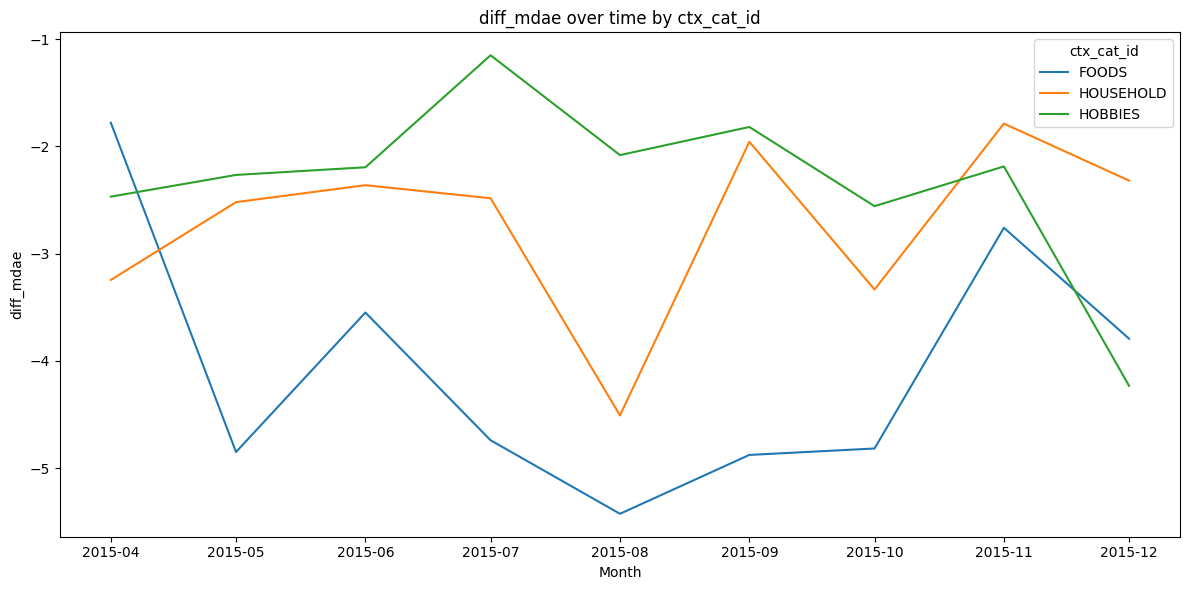

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_83908/4118172423.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

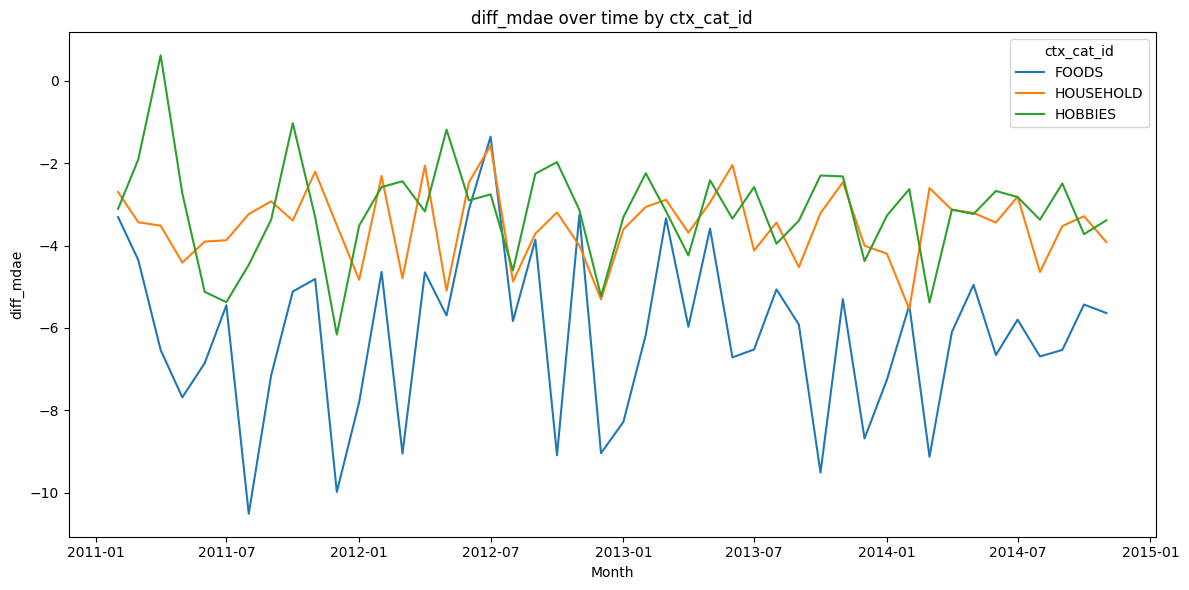

In [78]:
import matplotlib.pyplot as plt
def plot_error_per_col(df, col_name):
    df = df.copy()
    plt.figure(figsize=(12, 6))
    for col in df[col_name].unique():
        error_over_time = retrieve_error_per_group(
            df[df[col_name]==col], 
            "ctx_date_month"
        )
        error_over_time["diff_mdae"].plot(label=str(col))
    plt.title(f"diff_mdae over time by {col_name}")
    plt.xlabel("Month")
    plt.ylabel("diff_mdae")
    plt.legend(title=col_name)
    plt.tight_layout()
    plt.show()
    
plot_error_per_col(model.validation_df, "ctx_cat_id")
plot_error_per_col(model.training_df, "ctx_cat_id")

## 03. Define Function to Plot SHAPs

In [ ]:
import xgboost as xgb

def get_shaps(df):
    df = df.copy()

    # Shap table for validation:
    shaps_dataset = df[model.features]
    matrix_observation = xgb.DMatrix(shaps_dataset)

    # Assuming your model is named 'model' and your features are in 'X_train'
    shap_values = model.model.get_booster().predict(matrix_observation, pred_contribs=True)

    # 1. SHAP values DataFrame (excluding bias)
    shap_df = pd.DataFrame(shap_values[:, :-1], columns=model.features, index=shaps_dataset.index)

    # Reshape to long format with separate columns for value and SHAP value
    feature_long = shaps_dataset.reset_index().melt(id_vars='index', value_vars=shaps_dataset.columns, var_name='feature', value_name='feature_value')
    shap_long = shap_df.reset_index().melt(id_vars='index', value_vars=shap_df.columns, var_name='feature', value_name='shap_value')
    # Merge the two long DataFrames on observation index and feature name
    merged_long_df = pd.merge(feature_long, shap_long, on=['index', 'feature'])

    # Rename 'index' to 'observation' for clarity
    merged_long_df.rename(columns={'index': 'observation'}, inplace=True)
    merged_long_df["abs_shap_value"] = abs(merged_long_df['shap_value'])

    df["predictions"] = model.predict(df[model.features])
    df["error"] = (df["predictions"] - df[config_loader.target_col])/df[config_loader.target_col]

    merged_long_df_preds = merged_long_df.merge(
        df[['predictions', 'error', 'ctx_date_month', 'ctx_dept_id', 'ctx_cat_id', 'ctx_item_id']],
        left_on='observation',
        right_index=True,
        how='left'
    )

    return merged_long_df_preds
